In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import re
from collections import Counter

In [2]:
control = pd.read_csv('free_response_control.csv')
users = pd.read_csv('free_response_users.csv')

In [3]:
control_text = control.iloc[:, 0].dropna().astype(str).str.cat(sep=' ')
users_text = users.iloc[:, 0].dropna().astype(str).str.cat(sep=' ')

In [4]:
anticipated_impact = control.columns[0]
real_impact = users.columns[0]

In [5]:
def create_wordcloud(texts, title, filename):
    text_full = texts.dropna().astype(str).str.cat(sep=' ')
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_full)
    
    plt.figure(figsize = (10,5))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(title, fontsize = 16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [16]:
create_wordcloud(control[anticipated_impact], 'Anticipated Impact Word Cloud', 'control_wordcloud.png')
create_wordcloud(users[real_impact], 'Actual Impact', 'users_wordcloud.png')

In [7]:
def extract_emotional_words(text):
    words = re.findall(r'\b[A-Za-z]+\b', text.lower())
    emotional_words = []

    for word in words:
        sentiment = TextBlob(word).sentiment
        if abs(sentiment.polarity) > 0.05 or sentiment.subjectivity > 0.4:
            emotional_words.append(word)
            
    return ' '.join(emotional_words)

In [8]:
control_emo_text = extract_emotional_words(control_text)
users_emo_text = extract_emotional_words(users_text)

In [9]:
def create_emo_wordcloud(text, title, filename):
    wc = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [10]:
create_emo_wordcloud(control_emo_text, 'Control Group: Emotional/Subjective Words Only', 'control_emo_wordcloud.png')
create_emo_wordcloud(users_emo_text, 'Users Group: Emotional/Subjective Words Only', 'users_emo_wordcloud.png')

In [11]:
def get_word_stats(df, col_idx=0):
    text = df.iloc[:, col_idx].dropna().astype(str).str.cat(sep=' ').lower()
    words = re.findall(r'\b[a-z]{3,}\b', text)
    return Counter(words), len(words)

In [12]:
control_counts, control_total = get_word_stats(control)
user_counts, user_total = get_word_stats(users)

In [13]:
all_words = set(control_counts.keys()).union(set(user_counts.keys()))
results = []

In [14]:
for word in all_words:
    p = TextBlob(word).sentiment.polarity
    if p == 0: continue

    freq_user = (user_counts.get(word, 0) / user_total) * 1000
    freq_control = (control_counts.get(word, 0) / control_total) * 1000

    freq_diff = freq_user - freq_control
    impact_user = freq_user * p
    impact_control = freq_control * p
    impact_diff = impact_user - impact_control

    results.append({
        'word': word,
        'freq_diff': freq_diff,
        'impact_diff': impact_diff
    })

df_res = pd.DataFrame(results)

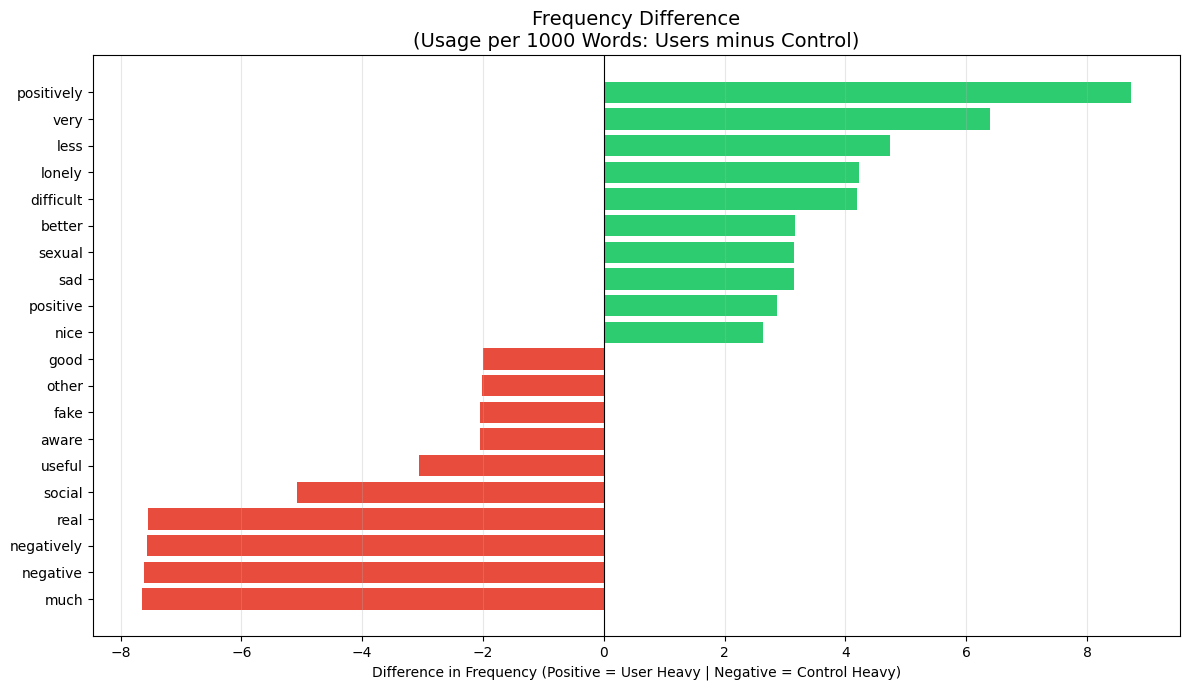

In [15]:
freq_pos = df_res.sort_values(by='freq_diff', ascending=False).head(10)
freq_neg = df_res.sort_values(by='freq_diff', ascending=True).head(10)
freq_plot = pd.concat([freq_pos, freq_neg]).sort_values(by='freq_diff')

plt.figure(figsize=(12, 7))
freq_colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in freq_plot['freq_diff']]
plt.barh(freq_plot['word'], freq_plot['freq_diff'], color=freq_colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Frequency Difference\n(Usage per 1000 Words: Users minus Control)', fontsize=14)
plt.xlabel('Difference in Frequency (Positive = User Heavy | Negative = Control Heavy)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()